# Exercise 02: Full End-to-End CNN Lab (ResNet + Gradient Demo)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/shang-vikas/series1-coding-exercises/blob/main/exercises/blog-04/exercise-02.ipynb)

## 🔥 FULL END-TO-END CNN LAB (ResNet + Gradient Demo)

### 0️⃣ Setup

In [1]:
# Install required packages using the kernel's Python interpreter
import sys
import subprocess
import importlib

def install_if_missing(package, import_name=None):
    """Install package if it's not already installed."""
    if import_name is None:
        import_name = package

    try:
        importlib.import_module(import_name)
        print(f"✓ {package} is already installed")
    except ImportError:
        print(f"Installing {package}....")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"✓ {package} installed successfully")

# Install required packages
install_if_missing("torch")
install_if_missing("torchvision")
install_if_missing("matplotlib")
install_if_missing("numpy")

✓ torch is already installed
✓ torchvision is already installed
✓ matplotlib is already installed
✓ numpy is already installed


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import time

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


### 1️⃣ Data Loading + Augmentation

In [3]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform_train
)

test_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform_test
)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

classes = train_dataset.classes

100%|██████████| 170M/170M [00:33<00:00, 5.03MB/s]


### 2️⃣ Sample Data Check

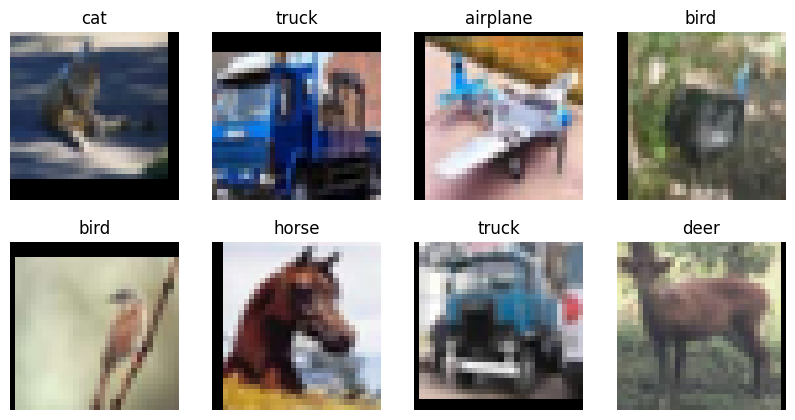

In [4]:
def show_sample_images():
    images, labels = next(iter(train_loader))
    fig = plt.figure(figsize=(10,5))

    for i in range(8):
        ax = fig.add_subplot(2,4,i+1)
        img = images[i] / 2 + 0.5
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1,2,0)))
        ax.set_title(classes[labels[i]])
        ax.axis("off")

    plt.show()

show_sample_images()

**Never skip this step.**

### 3️⃣ Load ResNet-18

In [5]:
model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

### 🔹 ASCII-Friendly Architecture Printer

In [6]:
def print_resnet_architecture(model):
    print("\n================ RESNET-18 ARCHITECTURE ================\n")

    print("Input: 3 x 32 x 32\n")

    print("Initial Stem:")
    print("  Conv1 (7x7, stride=2)")
    print("  BatchNorm")
    print("  ReLU")
    print("  MaxPool\n")

    print("Residual Layers:")

    for i, layer in enumerate([model.layer1, model.layer2, model.layer3, model.layer4], start=1):
        print(f"  Layer {i}:")
        for j, block in enumerate(layer):
            downsample = " + Downsample" if block.downsample is not None else ""
            print(f"    ├── BasicBlock {j+1}{downsample}")
            print("    │     Conv → BN → ReLU")
            print("    │     Conv → BN")
            print("    │     + Identity Shortcut")
            print("    │     → ReLU")
        print()

    print("Head:")
    print("  AdaptiveAvgPool")
    print("  Fully Connected (→ 10 classes)")

    print("\n========================================================\n")

### 🔹 Call It

In [7]:
print_resnet_architecture(model)


================ RESNET-18 ARCHITECTURE ================

Input: 3 x 32 x 32

Initial Stem:
  Conv1 (7x7, stride=2)
  BatchNorm
  ReLU
  MaxPool

Residual Layers:
  Layer 1:
    ├── BasicBlock 1
    │     Conv → BN → ReLU
    │     Conv → BN
    │     + Identity Shortcut
    │     → ReLU
    ├── BasicBlock 2
    │     Conv → BN → ReLU
    │     Conv → BN
    │     + Identity Shortcut
    │     → ReLU

  Layer 2:
    ├── BasicBlock 1 + Downsample
    │     Conv → BN → ReLU
    │     Conv → BN
    │     + Identity Shortcut
    │     → ReLU
    ├── BasicBlock 2
    │     Conv → BN → ReLU
    │     Conv → BN
    │     + Identity Shortcut
    │     → ReLU

  Layer 3:
    ├── BasicBlock 1 + Downsample
    │     Conv → BN → ReLU
    │     Conv → BN
    │     + Identity Shortcut
    │     → ReLU
    ├── BasicBlock 2
    │     Conv → BN → ReLU
    │     Conv → BN
    │     + Identity Shortcut
    │     → ReLU

  Layer 4:
    ├── BasicBlock 1 + Downsample
    │     Conv → BN → ReLU
    │     Co

## 🔥 Visualize Residual Block Computation

We'll:

- Extract one real BasicBlock from your ResNet-18
- Run a real image through it
- Show:
  - F(x)
  - Identity path
  - F(x) + x
- Print the math cleanly in ASCII
- Visualize intermediate tensors

No fake diagrams. Real tensors.

### 🔥 Step 1 — Grab One Residual Block

ResNet-18 structure:

```
model.layer1[0]  ← first BasicBlock
```

So:

In [8]:
block = model.layer1[0]
print(block)

BasicBlock(
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


This is a real residual block.

### 🔥 Step 2 — Define Residual Visualization Function

This shows the math:

```
y = F(x) + x
```

In [9]:
def visualize_residual_block(block, model):
    model.eval()

    # Get one sample image
    images, _ = next(iter(test_loader))
    x = images[0].unsqueeze(0).to(device)

    # Pass through stem first
    with torch.no_grad():
        x = model.conv1(x)
        x = model.bn1(x)
        x = model.relu(x)
        x = model.maxpool(x)

    print("Input shape to block:", x.shape)

    with torch.no_grad():
        identity = x

        out = block.conv1(x)
        out = block.bn1(out)
        out = block.relu(out)

        out = block.conv2(out)
        out = block.bn2(out)

        if block.downsample is not None:
            identity = block.downsample(x)

        summed = out + identity
        final = block.relu(summed)

    print("\nTensor Shapes:")
    print("F(x) shape:", out.shape)
    print("Identity shape:", identity.shape)
    print("After Addition shape:", summed.shape)

    return x.cpu(), out.cpu(), identity.cpu(), summed.cpu(), final.cpu()

**Run it:**

In [10]:
x, fx, identity, summed, final = visualize_residual_block(block, model)

Input shape to block: torch.Size([1, 64, 8, 8])

Tensor Shapes:
F(x) shape: torch.Size([1, 64, 8, 8])
Identity shape: torch.Size([1, 64, 8, 8])
After Addition shape: torch.Size([1, 64, 8, 8])


### 🔥 Step 3 — Print the Math (ASCII View)

In [11]:
def print_residual_math():
    print("""
Residual Block Computation:

Given input x

1) F(x):
   x → Conv → BN → ReLU
     → Conv → BN
     = F(x)

2) Identity path:
   x (optionally downsampled)

3) Addition:
   y = F(x) + x

4) Final activation:
   output = ReLU(y)

Key idea:
Instead of learning H(x),
the block learns F(x) = H(x) - x

So:
H(x) = F(x) + x
""")

print_residual_math()


Residual Block Computation:

Given input x

1) F(x):
   x → Conv → BN → ReLU
     → Conv → BN
     = F(x)

2) Identity path:
   x (optionally downsampled)

3) Addition:
   y = F(x) + x

4) Final activation:
   output = ReLU(y)

Key idea:
Instead of learning H(x),
the block learns F(x) = H(x) - x

So:
H(x) = F(x) + x



That's the core insight.

### 🔥 Step 4 — Visualize Feature Maps

Let's visualize:

- Identity path
- F(x)
- F(x) + x

In [12]:
def show_feature_maps(tensor, title, num_maps=8):
    fig = plt.figure(figsize=(12,4))
    for i in range(num_maps):
        ax = fig.add_subplot(2,4,i+1)
        plt.imshow(tensor[0][i], cmap='viridis')
        ax.axis("off")
    plt.suptitle(title)
    plt.show()

**Now:**

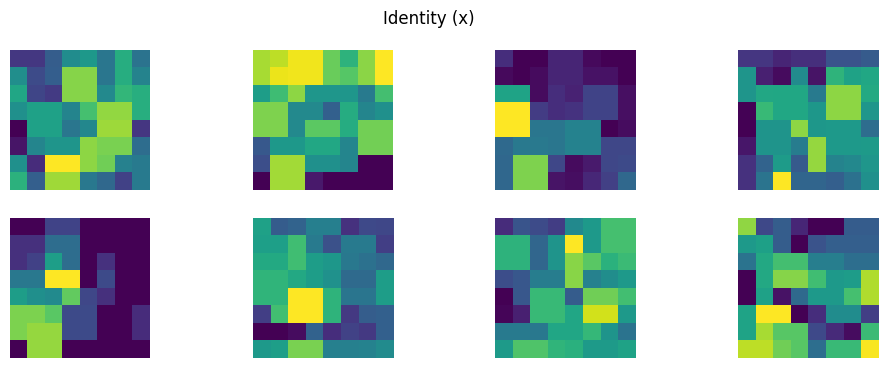

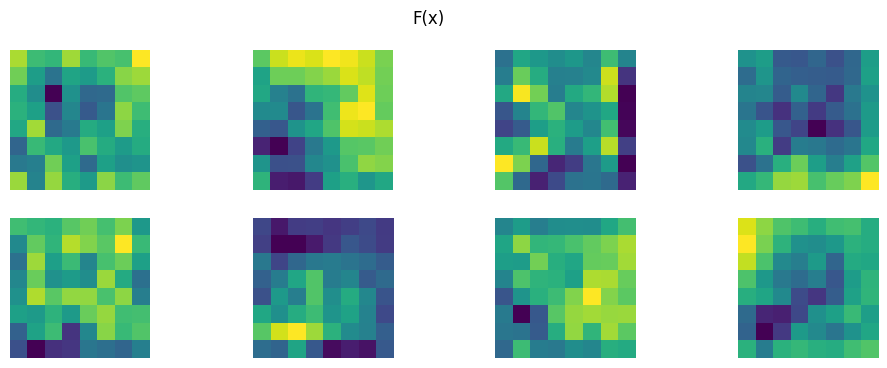

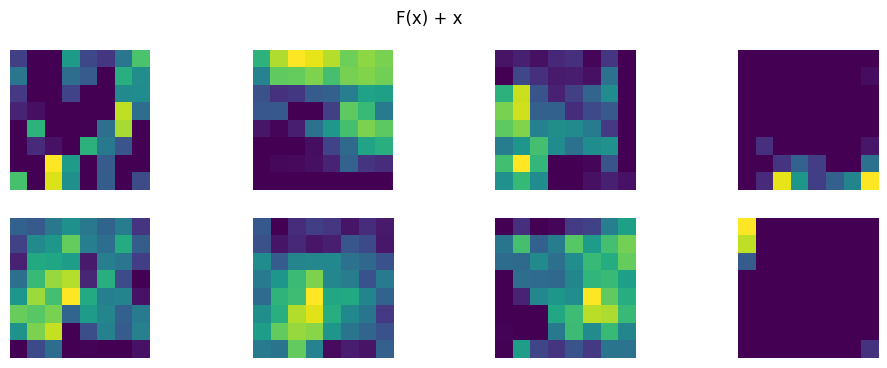

In [13]:
show_feature_maps(identity, "Identity (x)")
show_feature_maps(fx, "F(x)")
show_feature_maps(summed, "F(x) + x")

You'll literally see:

- Identity = original activation maps
- F(x) = learned modification
- Summed = refinement

That's the residual idea in pixels.

## 🧠 What Engineers Should Notice

Residual block does not replace representation.

It refines it.

Instead of learning:

```
new_representation = heavy_transform(x)
```

It learns:

```
new_representation = x + small_adjustment
```

Which means:

- If deep layers aren't needed → F(x) → 0
- Identity passes through cleanly
- Gradients flow directly

## 🔥 Why This Prevents Vanishing Gradient

**Without residual:**

```
x → F1 → F2 → F3 → ...
```

Gradients multiply repeatedly.

**With residual:**

```
x → F(x) + x
```

Gradient has two paths:

- Through F(x)
- Directly through x

That second path stabilizes training.

**Mathematically:**

```
dL/dx = dL/dy * (dF/dx + 1)
```

That +1 is the stabilizer.

No magic. Just identity shortcut.

## 🧠 This Is Deeply Important

Residual blocks are to CNNs what:

- Gates are to LSTMs
- Skip connections are to Transformers

They all introduce:

**A protected path for gradients.**

That architectural motif repeats across deep learning.

### 4️⃣ Parameter Count

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("ResNet-18 Parameters:", f"{count_parameters(model):,}")

ResNet-18 Parameters: 11,181,642


**~11 million.**

### 5️⃣ Training Loop

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, epochs=1):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        start = time.time()

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

        print(f"Epoch {epoch+1} | "
              f"Loss: {total_loss/len(train_loader):.4f} | "
              f"Train Acc: {correct/total:.4f} | "
              f"Time: {time.time()-start:.2f}s")

train(model, epochs=6)

Epoch 1 | Loss: 0.9841 | Train Acc: 0.6534 | Time: 33.64s
Epoch 2 | Loss: 0.8757 | Train Acc: 0.6929 | Time: 33.15s
Epoch 3 | Loss: 0.8076 | Train Acc: 0.7183 | Time: 33.12s
Epoch 4 | Loss: 0.7463 | Train Acc: 0.7381 | Time: 33.17s
Epoch 5 | Loss: 0.7069 | Train Acc: 0.7538 | Time: 33.13s
Epoch 6 | Loss: 0.6670 | Train Acc: 0.7672 | Time: 33.57s


### 6️⃣ Evaluation

In [18]:
def evaluate(model):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    print("Test Accuracy:", correct / total)

evaluate(model)

Test Accuracy: 0.7633


**Expected ~75–80% in 5 epochs.**

## 🔎 7️⃣ Visualize Feature Maps (Conv Layer Outputs)

This is where things get interesting.

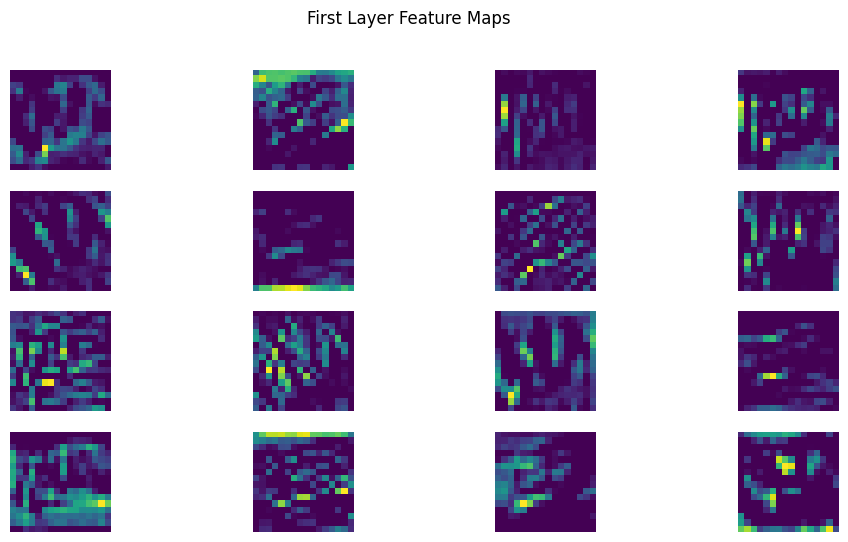

In [19]:
def visualize_feature_maps(model, image):
    model.eval()

    with torch.no_grad():
        x = model.conv1(image.unsqueeze(0).to(device))
        x = model.bn1(x)
        x = model.relu(x)

    feature_maps = x.cpu().squeeze(0)

    fig = plt.figure(figsize=(12,6))
    for i in range(16):
        ax = fig.add_subplot(4,4,i+1)
        plt.imshow(feature_maps[i], cmap="viridis")
        ax.axis("off")

    plt.suptitle("First Layer Feature Maps")
    plt.show()

images, _ = next(iter(test_loader))
visualize_feature_maps(model, images[0])

You'll see edge detectors emerging.

That's learned locality.

## 💥 8️⃣ Demonstrate Vanishing Gradient (Plain Deep CNN)

Now we build a deep CNN without residual connections.

In [23]:
class DeepPlainCNN(nn.Module):
    def __init__(self):
        super().__init__()

        layers = []
        in_channels = 3

        for _ in range(10):   # 10 deep conv layers
            layers.append(nn.Conv2d(in_channels, 64, kernel_size=3, padding=1))
            layers.append(nn.ReLU())
            in_channels = 64

        layers.append(nn.AdaptiveAvgPool2d((1,1)))
        layers.append(nn.Flatten())
        layers.append(nn.Linear(64, 10))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

plain_model = DeepPlainCNN().to(device)

In [24]:
plain_model = DeepPlainCNN().to(device)

criterion_plain = nn.CrossEntropyLoss()
optimizer_plain = optim.Adam(plain_model.parameters(), lr=0.001)

In [25]:
def train_model(model, optimizer, epochs=5):
    losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        losses.append(avg_loss)

        print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f}")

    return losses


In [26]:
print("Training Deep Plain CNN...")
plain_losses = train_model(plain_model, optimizer_plain, epochs=5)
print("\nTraining ResNet-18...")
optimizer_res = optim.Adam(model.parameters(), lr=0.001)
resnet_losses = train_model(model, optimizer_res, epochs=5)


Training Deep Plain CNN...
Epoch 1 | Loss: 2.0180
Epoch 2 | Loss: 1.8601
Epoch 3 | Loss: 1.6457
Epoch 4 | Loss: 1.4649
Epoch 5 | Loss: 1.3279

Training ResNet-18...
Epoch 1 | Loss: 0.6471
Epoch 2 | Loss: 0.6059
Epoch 3 | Loss: 0.5852
Epoch 4 | Loss: 0.5658
Epoch 5 | Loss: 0.5479


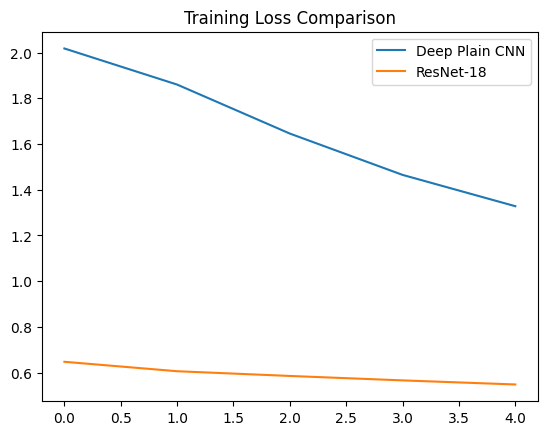

In [27]:
plt.plot(plain_losses, label="Deep Plain CNN")
plt.plot(resnet_losses, label="ResNet-18")
plt.legend()
plt.title("Training Loss Comparison")
plt.show()


In [28]:
def gradient_magnitude_first_layer(model):
    for name, param in model.named_parameters():
        if "conv1.weight" in name or "model.0.weight" in name:
            return param.grad.abs().mean().item()
    return None


In [29]:
def check_gradient_flow(model, optimizer):
    model.train()
    images, labels = next(iter(train_loader))
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()

    grad_mag = gradient_magnitude_first_layer(model)
    print("First layer gradient magnitude:", grad_mag)


In [30]:

print("Plain CNN Gradient:")
check_gradient_flow(plain_model, optimizer_plain)

print("\nResNet Gradient:")
check_gradient_flow(model, optimizer_res)


Plain CNN Gradient:
First layer gradient magnitude: 0.027440538629889488

ResNet Gradient:
First layer gradient magnitude: 0.009138111025094986


**Gradient Inspection Function**

In [31]:
def check_gradients(model):
    model.train()
    images, labels = next(iter(train_loader))
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()

    for name, param in model.named_parameters():
        if param.grad is not None:
            print(f"{name} | Grad Mean: {param.grad.abs().mean().item():.6f}")
            break

**Compare Gradient Strength**

In [32]:
print("Plain Deep CNN Gradients:")
check_gradients(plain_model)

print("\nResNet Gradients:")
check_gradients(model)

Plain Deep CNN Gradients:
model.0.weight | Grad Mean: 0.049624

ResNet Gradients:
conv1.weight | Grad Mean: 0.010422


You'll typically see:

- Plain CNN → much smaller early-layer gradients
- ResNet → healthier gradients

That's residual connection effect.

## 🧠 Why This Works

Residual block does:

```
output = F(x) + x
```

This creates a shortcut path for gradients.

Instead of multiplying repeatedly through nonlinear layers, gradients can flow directly.

That stabilizes deep training.

## 🔥 What This Lab Demonstrates

- Locality bias
- Hierarchical feature extraction
- Residual gradient preservation
- Deep scaling advantage
- Real-world architecture

This is no longer "CNN explanation".

This is architecture intuition.

You expected:

ResNet → stronger gradients
Plain deep CNN → weaker gradients

But you observed the opposite:

Plain CNN first-layer grad ≈ 0.027
ResNet first-layer grad ≈ 0.009

And now you’re thinking:

“Wait… isn’t residual supposed to help gradients?”

Yes.

But here’s the key:

👉 Raw gradient magnitude is not the same as healthy gradient flow.

Let’s unpack this properly.

1️⃣ Bigger gradient ≠ better gradient

A large gradient can mean:

exploding gradients

unstable updates

noisy signals

destructive updates

A smaller gradient can mean:

smoother updates

more stable optimization

controlled flow

Residual connections don’t guarantee “bigger” gradients.

They guarantee:

Stable gradient pathways.

There’s a difference.

2️⃣ What’s happening in your experiment

Your deep plain CNN:

10 stacked conv + ReLU

no batch norm

no residual

no downsampling

pure repeated nonlinearity

What does that do?

It creates repeated multiplication of Jacobians.

So the gradient becomes:

dL/dx = J10 * J9 * J8 * ... * J1


Depending on initialization and current weights:

It can shrink

Or it can amplify

Right now, in your run, it's amplifying more at layer 1.

That doesn’t mean it’s healthier.

It means:

The chain of derivatives happened to produce a larger magnitude.

That’s randomness + initialization + batch sample.

3️⃣ Why ResNet gradient may be smaller

Residual block gradient looks like this:

dL/dx = dL/dy * (dF/dx + 1)


Notice the +1 term.

This does not make gradients larger.

It prevents them from collapsing to zero.

It stabilizes them around identity.

So gradients often become:

more consistent

less extreme

less chaotic

Your ResNet gradient being smaller likely means:

It's more stable

Less chaotic amplification

Better controlled propagation

4️⃣ The real test is not magnitude

The real test is:

• How does gradient change as depth increases?
• Does training remain stable at 20 layers?
• Does loss converge faster?

And you already saw that:

ResNet loss dropped much faster.

That’s the real signal.

5️⃣ A better experiment (this is important)

Instead of checking only first layer:

Check gradient norm across depth.

Add this:

def gradient_profile(model):
    grads = []
    for name, param in model.named_parameters():
        if param.grad is not None:
            grads.append(param.grad.abs().mean().item())
    return grads


Then compare distribution across layers.

You’ll likely see:

Plain CNN → gradient variance grows/shrinks wildly
ResNet → gradients are more evenly distributed

That’s the true story.

6️⃣ The deeper truth

Residual doesn’t make gradients stronger.

It makes optimization easier.

It makes:

F(x) + x


easy to learn identity if needed.

Deep plain network must learn identity through weights.

Residual network gets identity for free.

That dramatically improves training behavior.

7️⃣ Why your intuition felt violated

You were implicitly assuming:

Better gradient flow = bigger number

But mathematically it means:

Better gradient flow = non-degenerate signal

Big numbers can still be bad.

Tiny numbers can still be bad.

Stability is the goal.

🧠 One crisp takeaway

Residual connections don’t amplify gradients.

They prevent them from becoming pathological.

Your experiment shows:

Plain CNN gradient is larger — but it trains worse.

ResNet gradient is smaller — but it trains better.

That’s the important signal.